In [0]:
dbutils.library.installPyPI('tsmoothie')
dbutils.library.installPyPI('tslearn')
dbutils.library.installPyPI('yfinance')
dbutils.library.restartPython()
dbutils.library.list()

Out[1]: ['tslearn', 'tsmoothie', 'yfinance']

In [0]:
from tsmoothie.smoother import *
import warnings
warnings.simplefilter('ignore')
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
import matplotlib.pyplot as plt

In [0]:
# df_ts_base = spark.sql(f"""select trans_dt, count(distinct pos_trans_id) as num_txns, sum(sl_qty) as qty_sold from default.cnsld_pos_trans_item 
# where 
# co_id = 1
# and lcl_sl_wgt_qty + sl_qty > 0
# and sl_amt > 0 
# AND SCAN_CD NOT IN (71636,70176,71606,54885)
# AND LCL_SL_TRANS_TY_CD IN ('1001','1901','9101')
# AND LCL_SL_ITEM_TY_CD NOT IN ('2004','2005')  
# and trim(lcl_artcl_num) in (select distinct trim(artcl_num) from bpo_architecture.artcl_ah_lkup where ah_5_cd = '237277') group by 1""")
# df_ts_base.write.format("delta").mode("overwrite").saveAsTable("priceoptimization_product.ts_base_data")

In [0]:
df_ts = spark.sql(f"""select trans_dt, qty_sold from priceoptimization_product.ts_base_data order by trans_dt""").toPandas()
df_ts = df_ts.set_index(['trans_dt'])
df_ts['qty_sold_int'] = df_ts['qty_sold'].astype(int)
df_ts.head()

,qty_sold,qty_sold_int
trans_dt,,
2016-01-01,1115.000,1115
2016-01-02,9261.000,9261
2016-01-03,6776.000,6776
2016-01-04,6087.000,6087
2016-01-05,6233.000,6233


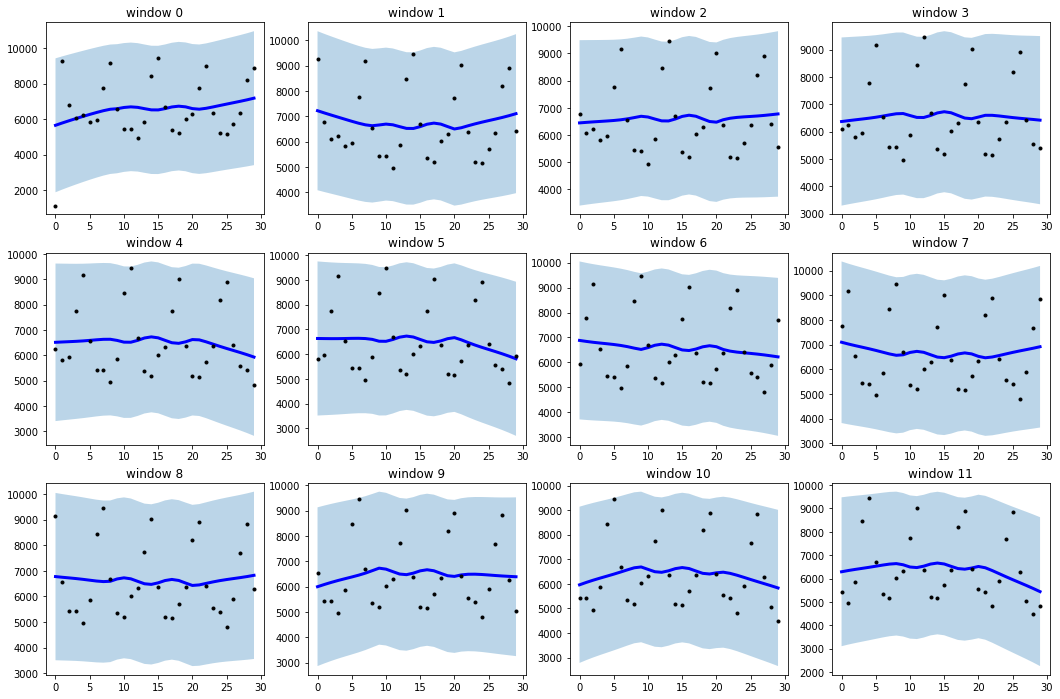

In [0]:
### SMOOTH ###

window_shape = 30

smoother = WindowWrapper(LowessSmoother(smooth_fraction=0.6, iterations=1), 
                         window_shape=window_shape)
smoother.smooth(df_ts['qty_sold_int'])

low, up = smoother.get_intervals('prediction_interval') # only for visualization

### PLOT THE FIRST 12 SMOOTHED WINDOWS ###

plt.figure(figsize=(18,12))

for i,(true,smooth) in enumerate(zip(smoother.Smoother.data, smoother.Smoother.smooth_data)):
    
    if i == 12:
        break
    
    plt.subplot(3,4, i+1)
    plt.plot(smooth, linewidth=3, color='blue')
    plt.plot(true, '.k')
    plt.fill_between(range(len(true)), low[i], up[i], alpha=0.3)
    plt.title(f"window {i}")

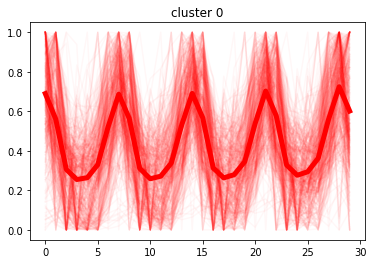

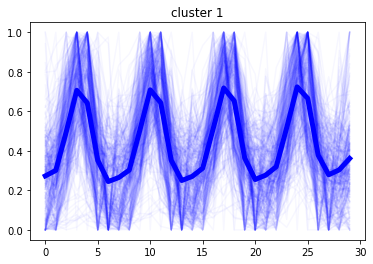

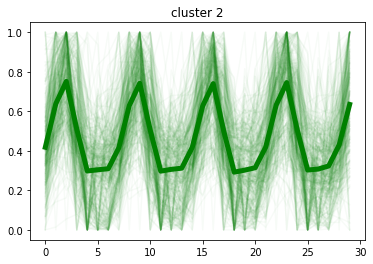

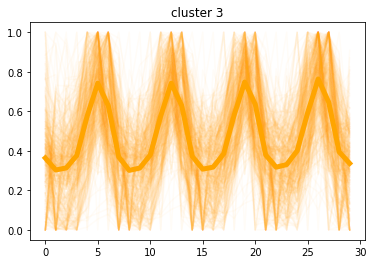

In [0]:
### NO SMOOTHING EUCLIDEAN ###

### SCALE RAW WINDOWS ###

raw_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.data)

# ### CLUSTER WINDOWS ###

raw_km = TimeSeriesKMeans(n_clusters=4, metric="euclidean", max_iter=10, random_state=33)
raw_km.fit(raw_scaled)

### PLOT CLUSTER CENTERS WITH SAMPLES ###

colors = {0:'red',1:'blue',2:'green',3:'orange'}

for c in range(raw_km.n_clusters):
    
    plt.plot(np.squeeze(raw_scaled[raw_km.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(raw_km.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

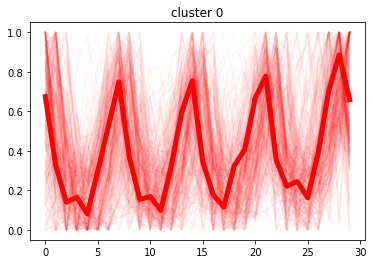

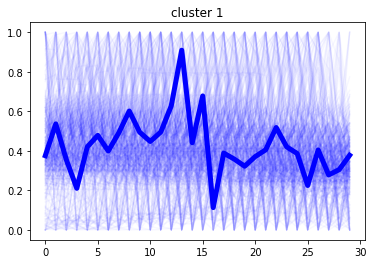

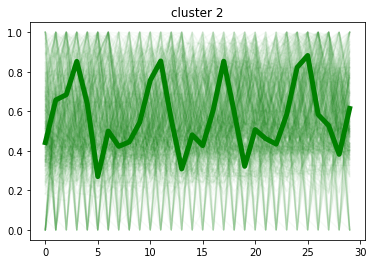

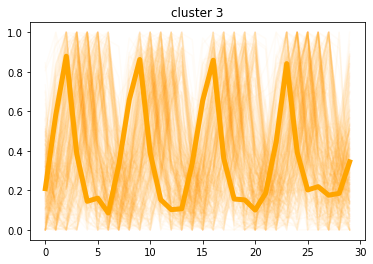

In [0]:
### NO SMOOTHING DTW ###

### SCALE RAW WINDOWS ###

raw_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.data)

# ### CLUSTER WINDOWS ###

raw_km = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=33)
raw_km.fit(raw_scaled)

### PLOT CLUSTER CENTERS WITH SAMPLES ###

colors = {0:'red',1:'blue',2:'green',3:'orange'}

for c in range(raw_km.n_clusters):
    
    plt.plot(np.squeeze(raw_scaled[raw_km.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(raw_km.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

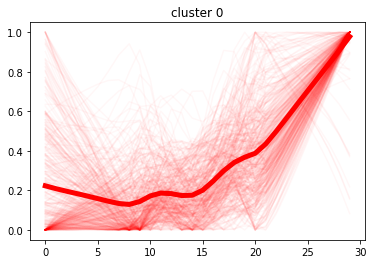

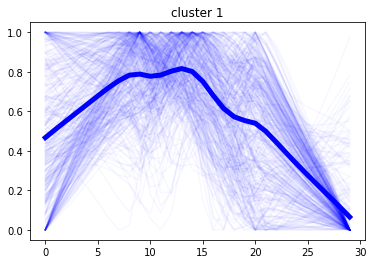

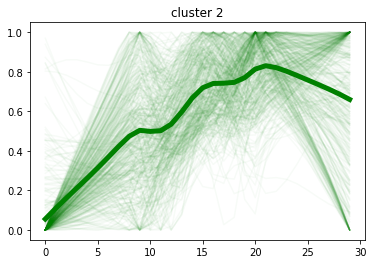

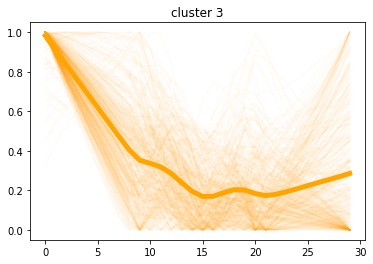

In [0]:
 ### SCALE SMOOTHED WINDOWS  EUCLIDEAN###

smooth_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.smooth_data)
smooth_scaled.shape

### CLUSTER SMOOTHED WINDOWS ###

smooth_km = TimeSeriesKMeans(n_clusters=4, metric="euclidean", max_iter=10, random_state=33)
smooth_km.fit(smooth_scaled)

### PLOT CLUSTER CENTERS WITH SAMPLES ###

colors = {0:'red',1:'blue',2:'green',3:'orange'}

for c in range(smooth_km.n_clusters):
    
    plt.plot(np.squeeze(smooth_scaled[smooth_km.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(smooth_km.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

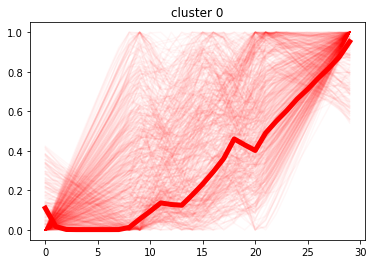

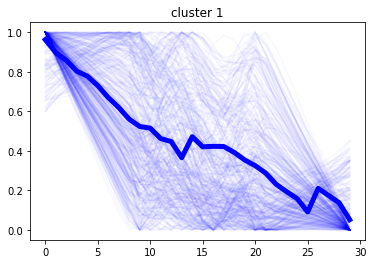

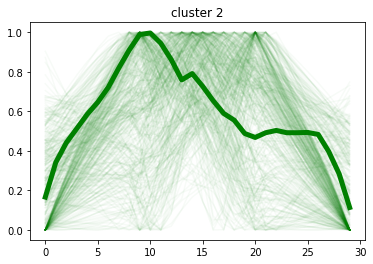

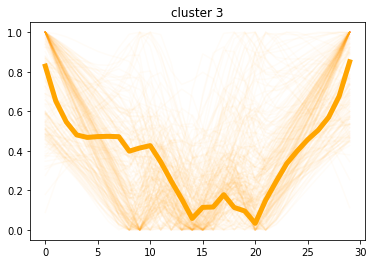

In [0]:
 ### SCALE SMOOTHED WINDOWS DTW ###

smooth_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.smooth_data)
smooth_scaled.shape

### CLUSTER SMOOTHED WINDOWS ###

smooth_km = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=33)
smooth_km.fit(smooth_scaled)

### PLOT CLUSTER CENTERS WITH SAMPLES ###

colors = {0:'red',1:'blue',2:'green',3:'orange'}

for c in range(smooth_km.n_clusters):
    
    plt.plot(np.squeeze(smooth_scaled[smooth_km.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(smooth_km.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

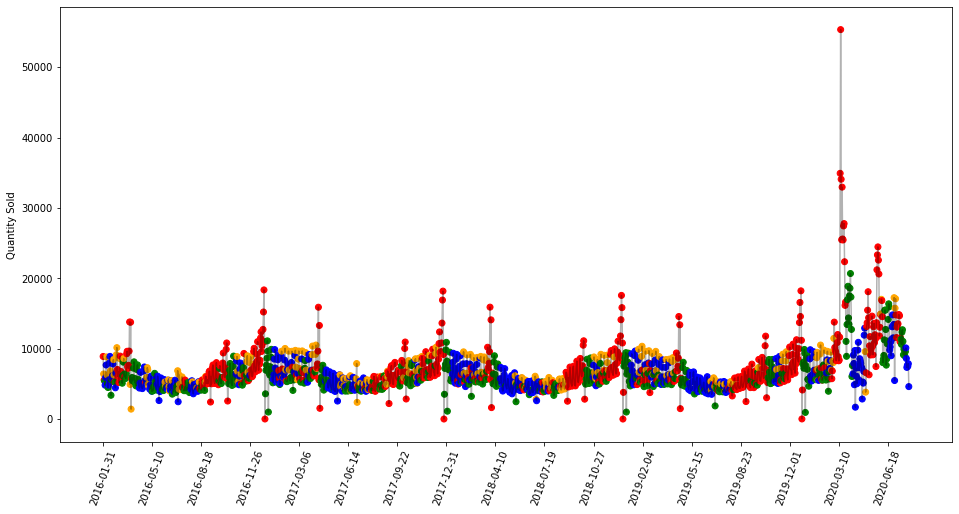

In [0]:
### PLOT CLUSTER ON THE RAW TIME SERIES ###

plt.figure(figsize=(16,8))

plt.plot(smoother.Smoother.data[:,-1], c='black', alpha=0.3)
plt.scatter(range(len(smoother.Smoother.data[:,-1])), smoother.Smoother.data[:,-1], 
            c=[colors[c] for c in smooth_km.labels_])

plt.xticks(range(0,len(df_ts.index.unique())-window_shape, 100), 
           df_ts.index.unique()[window_shape::100], rotation=70)
plt.ylabel('Quantity Sold')
np.set_printoptions(False)

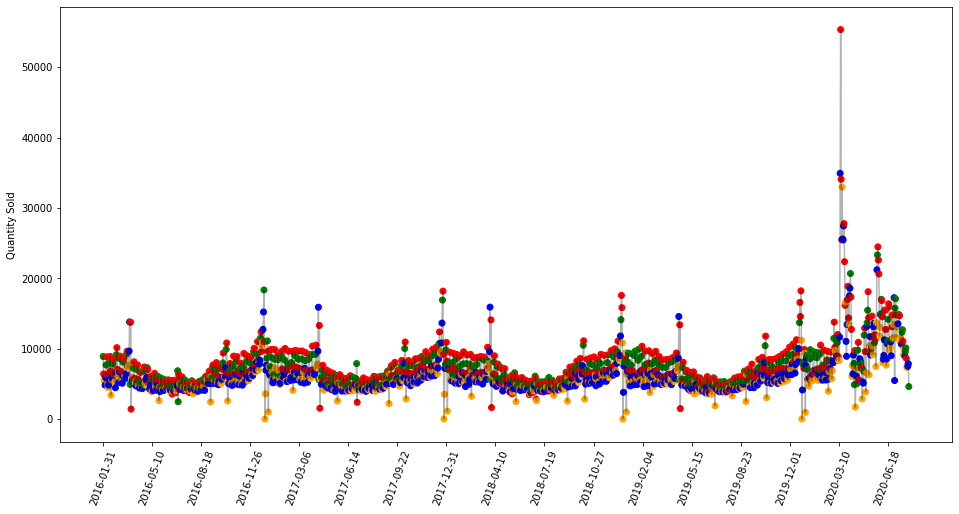

In [0]:
### PLOT CLUSTER ON THE RAW TIME SERIES ###

plt.figure(figsize=(16,8))

plt.plot(smoother.Smoother.data[:,-1], c='black', alpha=0.3)
plt.scatter(range(len(smoother.Smoother.data[:,-1])), smoother.Smoother.data[:,-1], 
            c=[colors[c] for c in raw_km.labels_])

plt.xticks(range(0,len(df_ts.index.unique())-window_shape, 100), 
           df_ts.index.unique()[window_shape::100], rotation=70)
plt.ylabel('Quantity Sold')
np.set_printoptions(False)

END

In [0]:
# Article Example
import yfinance as yf
from tsmoothie.smoother import *
import warnings
warnings.simplefilter('ignore')
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
import matplotlib.pyplot as plt

df_ts = yf.Ticker('AMZN').history(period='1d', start='2010-01-01', end='2020-01-01')[["Close"]]

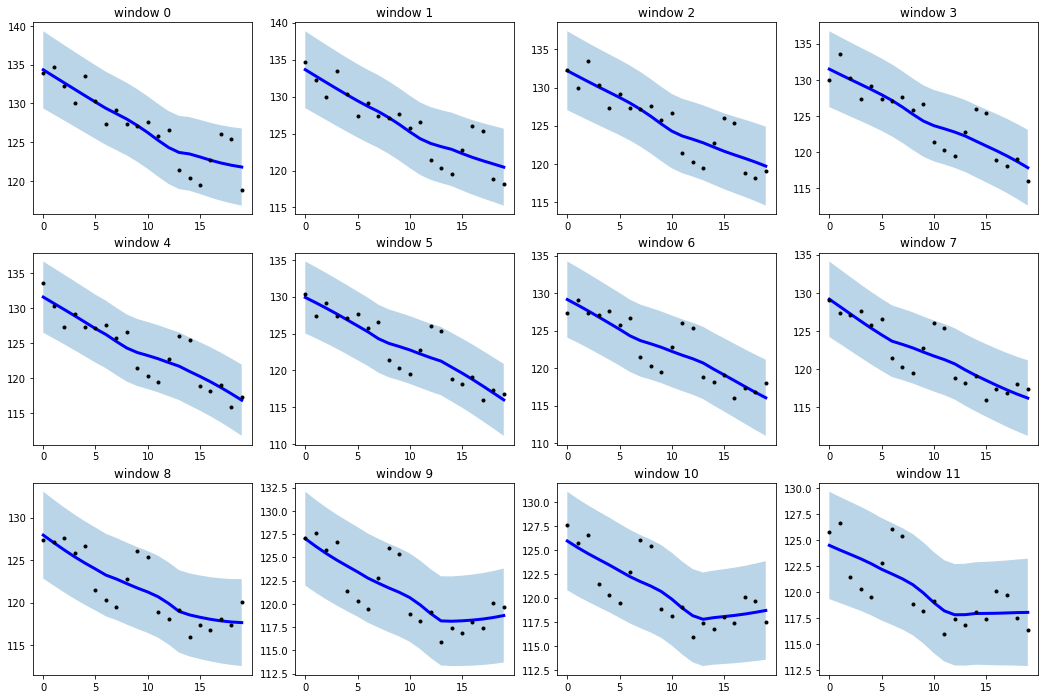

In [0]:
### SMOOTH PRICE ###

window_shape = 20

smoother = WindowWrapper(LowessSmoother(smooth_fraction=0.6, iterations=1), 
                         window_shape=window_shape)
smoother.smooth(df_ts)

low, up = smoother.get_intervals('prediction_interval') # only for visualization

### PLOT THE FIRST 12 SMOOTHED WINDOWS ###

plt.figure(figsize=(18,12))

for i,(true,smooth) in enumerate(zip(smoother.Smoother.data, smoother.Smoother.smooth_data)):
    
    if i == 12:
        break
    
    plt.subplot(3,4, i+1)
    plt.plot(smooth, linewidth=3, color='blue')
    plt.plot(true, '.k')
    plt.fill_between(range(len(true)), low[i], up[i], alpha=0.3)
    plt.title(f"window {i}")

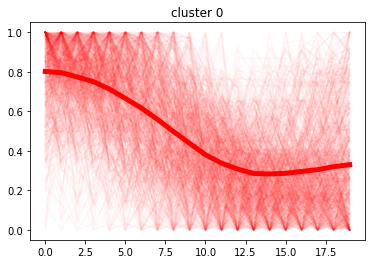

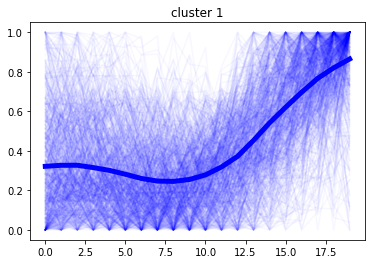

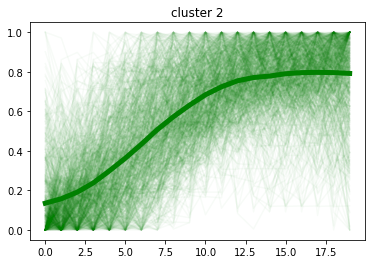

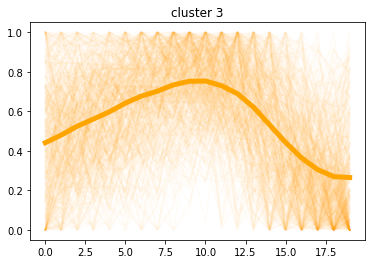

In [0]:
### NO SMOOTHING EUCLIDEAN ###

### SCALE RAW WINDOWS ###

raw_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.data)

# ### CLUSTER WINDOWS ###

raw_km = TimeSeriesKMeans(n_clusters=4, metric="euclidean", max_iter=10, random_state=33)
raw_km.fit(raw_scaled)

### PLOT CLUSTER CENTERS WITH SAMPLES ###

colors = {0:'red',1:'blue',2:'green',3:'orange'}

for c in range(raw_km.n_clusters):
    
    plt.plot(np.squeeze(raw_scaled[raw_km.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(raw_km.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

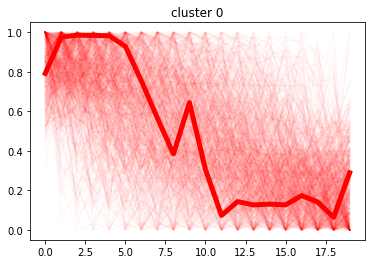

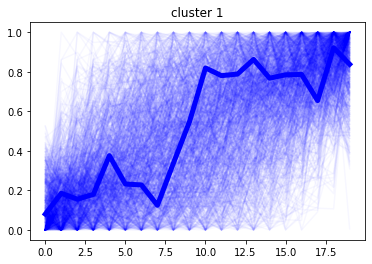

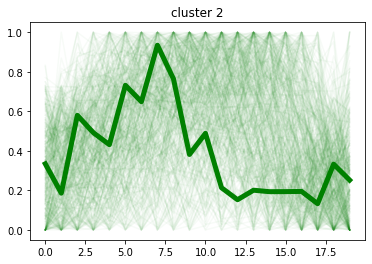

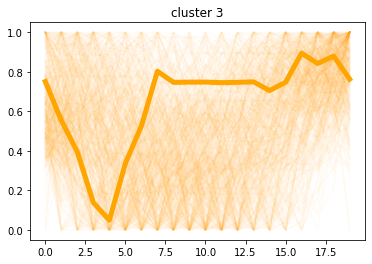

In [0]:
### NO SMOOTHING DTW ###

### SCALE RAW WINDOWS ###

raw_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.data)

# ### CLUSTER WINDOWS ###

raw_km = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=33)
raw_km.fit(raw_scaled)

### PLOT CLUSTER CENTERS WITH SAMPLES ###

colors = {0:'red',1:'blue',2:'green',3:'orange'}

for c in range(raw_km.n_clusters):
    
    plt.plot(np.squeeze(raw_scaled[raw_km.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(raw_km.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

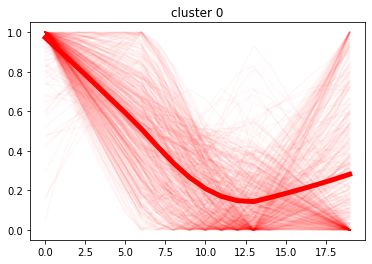

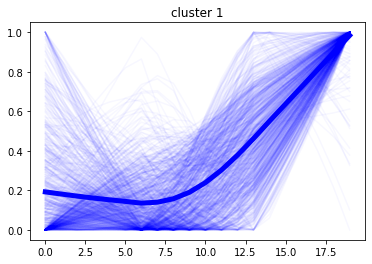

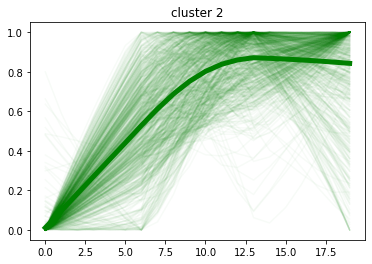

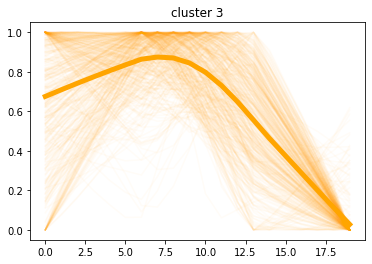

In [0]:
 ### SCALE SMOOTHED WINDOWS  EUCLIDEAN###

smooth_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.smooth_data)
smooth_scaled.shape

### CLUSTER SMOOTHED WINDOWS ###

smooth_km = TimeSeriesKMeans(n_clusters=4, metric="euclidean", max_iter=10, random_state=33)
smooth_km.fit(smooth_scaled)

### PLOT CLUSTER CENTERS WITH SAMPLES ###

colors = {0:'red',1:'blue',2:'green',3:'orange'}

for c in range(smooth_km.n_clusters):
    
    plt.plot(np.squeeze(smooth_scaled[smooth_km.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(smooth_km.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

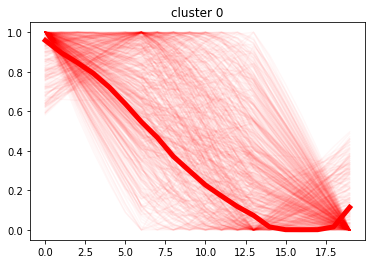

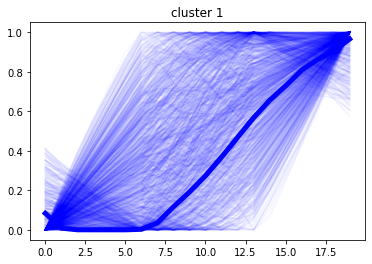

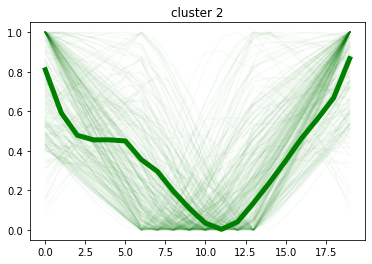

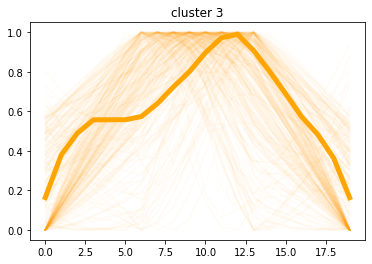

In [0]:
 ### SCALE SMOOTHED WINDOWS DTW ###

smooth_scaled = TimeSeriesScalerMinMax().fit_transform(smoother.Smoother.smooth_data)
smooth_scaled.shape

### CLUSTER SMOOTHED WINDOWS ###

smooth_km = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10, random_state=33)
smooth_km.fit(smooth_scaled)

### PLOT CLUSTER CENTERS WITH SAMPLES ###

colors = {0:'red',1:'blue',2:'green',3:'orange'}

for c in range(smooth_km.n_clusters):
    
    plt.plot(np.squeeze(smooth_scaled[smooth_km.labels_ == c],-1).T, c=colors[c], alpha=0.03)
    plt.plot(np.squeeze(smooth_km.cluster_centers_, -1)[c], c=colors[c], linewidth=5)
    plt.title(f"cluster {c}")
    
    plt.show()

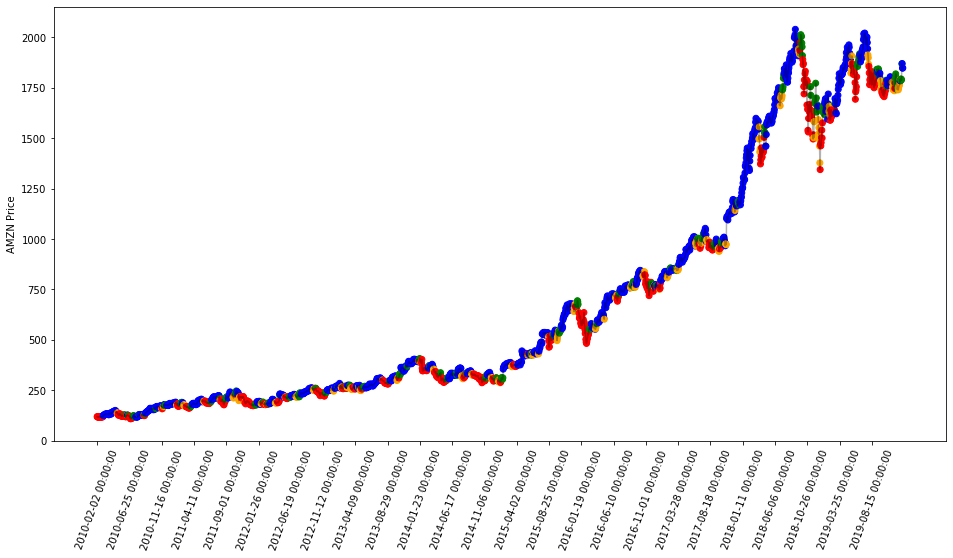

In [0]:
### PLOT CLUSTER ON THE RAW TIME SERIES ###

plt.figure(figsize=(16,8))

plt.plot(smoother.Smoother.data[:,-1], c='black', alpha=0.3)
plt.scatter(range(len(smoother.Smoother.data[:,-1])), smoother.Smoother.data[:,-1], 
            c=[colors[c] for c in smooth_km.labels_])

plt.xticks(range(0,len(df_ts.index.unique())-window_shape, 100), 
           df_ts.index.unique()[window_shape::100], rotation=70)
plt.ylabel('AMZN Price')
np.set_printoptions(False)